In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors, cm
import os
import re
import seaborn as sns
from itertools import cycle
from collections import namedtuple
import Bio
from Bio.PDB import PDBParser
from biopandas.pdb import PandasPdb
from scipy.spatial.distance import euclidean
import itertools
import utility
import networkx as nx
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
from sklearn import preprocessing
from itertools import combinations
import math
import heapq
import cvxpy as cvx
import networkit as nk
import time
from collections import Counter
import collections
from mpl_toolkits.mplot3d import Axes3D 
from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import offline
from Proteins import nodes, edges, no_weight, norm_weight, ollivier_ricci_node, ollivier_ricci_edge, edge_sort, node_connect_path, get_single_node_neighbors_distributions, source_target_shortest_path, optimal_transportation_distance, xyd, G_optimal_path_w, G_optimal_path, G_shortest_path_w, G_shortest_path, path_pd_all_w, path_pd_all, path_sum_mean, edge_node_vec, node_based_torsion, edge_node_vec_torsion, angle, mirror_point, find_pair_node_chiral, find_symmetric_point_and_plane_chiral, mirror_check_chiral, chirality_sign

In [2]:
point_dir = os.path.join(os.getcwd(), 'PDB_files')
_base = math.e
_exp_power = 2
_alpha = 0.5
_nbr_topk = 1000
EPSILON = 1e-7 

'/home/minjcha/Documents/Chrality_measure/protein_3by7'

In [3]:
pdb_files = [f for f in os.listdir(point_dir) if f.endswith('.pdb')]

pdb_files

['3by7_C.pdb', '3by7.pdb']

In [4]:
coord = PandasPdb()
coord.read_pdb(os.path.join(point_dir, pdb_files[0]))
print(coord.df.keys())
c_id = coord.df['ATOM']['chain_id'].unique()
print(c_id)

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])
['C']


In [7]:
coord.df['ATOM']['residue_number']=np.arange(len(coord.df['ATOM']))

In [9]:
def get_point_pdb(file_num):
    
    coord = PandasPdb()
    coord.read_pdb(os.path.join(point_dir, pdb_files[file_num]))
    c1 = coord.df['ATOM']
    c1 = c1[c1['atom_name']== 'CA']
    c1_xyz = np.hstack([np.array(c1['x_coord']).reshape(-1,1), np.array(c1['y_coord']).reshape(-1,1)
                 , np.array(c1['z_coord']).reshape(-1,1)])
    
    
    xyz = pd.DataFrame(np.zeros((len(c1), 4)), columns=['ATOM', 'x', 'y', 'z'])

    xyz['x'] = c1_xyz[:,0]
    xyz['y'] = c1_xyz[:,1]
    xyz['z'] = c1_xyz[:,2]
    
    return xyz

In [11]:
#chiral clusters

xyz_l = get_point_pdb(0)



Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


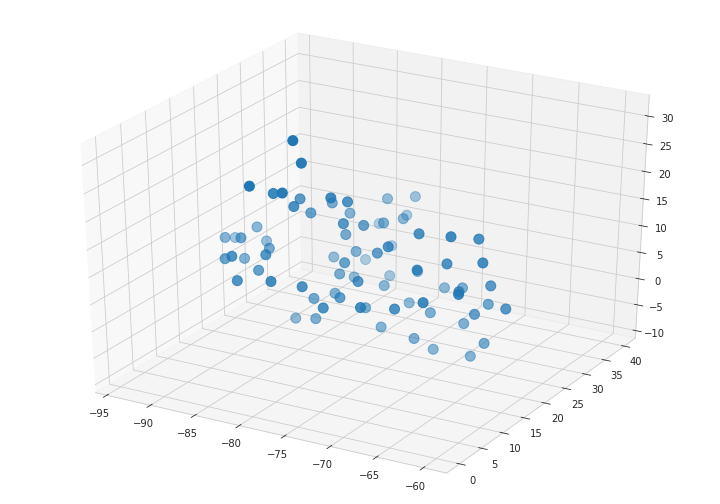

/home/minjcha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

divide by zero encountered in true_divide



In [184]:

%matplotlib inline  
%matplotlib notebook
%pylab

fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)


a = 1
b = 0
c = 0
d = -1 

x = np.linspace(-80,-60, 1000)
y = np.linspace(0,40, 1000)

X,Y = np.meshgrid(x,y)
Z = (d - a*X - b*Y) / c

surf = ax.plot_surface(X, Y, Z)


ax.scatter(xyz_l['x'], xyz_l['y'], xyz_l['z'], s=100)
# ax.view_init(90,90)


plt.show()

In [15]:
# chiral 
thre = 1
al = 7

node_l = nodes(xyz_l)
edge_l = edges(xyz_l, node_l, al, thre)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

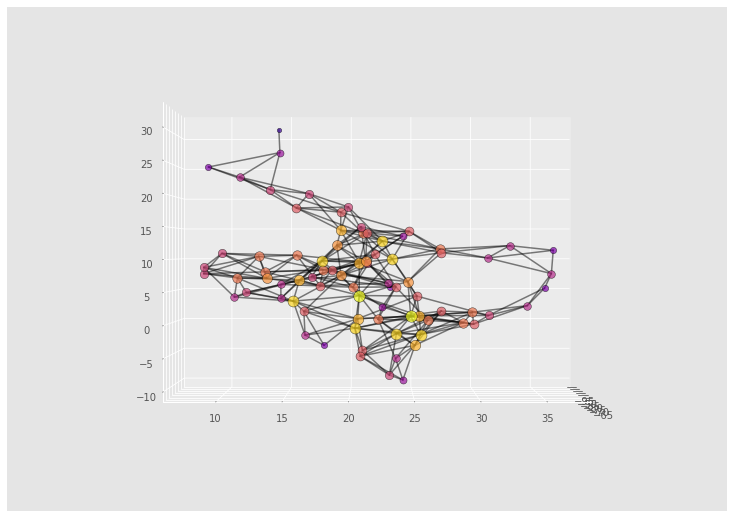

In [17]:
pos_G(xyz_l, node_l, edge_l)

In [16]:
def pos_G(xyz, node, edge):
    
    pos = {ii: (xyz.iloc[ii,1:].to_numpy()) for ii in range(len(xyz))}
    G = nx.Graph()
    G.add_nodes_from(node)
    G.add_edges_from(edge)
    
    from mpl_toolkits.mplot3d import Axes3D
    n = G.number_of_nodes()
    edge_max = max([G.degree(i) for i in range(n)])
    colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 
    with plt.style.context(('ggplot')):
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            # Scatter plot
            ax.scatter(xi, yi, zi, c=colors[key], s=10+10*G.degree(key), edgecolors='k', alpha=0.7)
        for i,j in enumerate(G.edges()):
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
            # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.5)
        ax.view_init(0, 0)

In [22]:
#chiral

Gw_l = norm_weight(xyz_l, node_l, edge_l)
G_l = no_weight(node_l, edge_l)

orn_w_l = ollivier_ricci_node(Gw_l, 0.5)
ore_w_l = ollivier_ricci_edge(Gw_l,0.5)

orn_l = ollivier_ricci_node(G_l, 0.5)
ore_l = ollivier_ricci_edge(G_l,0.5)



In [35]:
#chiral
   
e_l = np.asarray(list(Gw_l.edges()))
    
path_l = []
path_l_w = []

for ii in range(len(e_l)):
    com, con, path = node_connect_path(e_l, e_l[ii])
    path_l.append(path)
    
for ii in range(len(e_l)):
    com, con, path = node_connect_path(e_l, e_l[ii])
    path_l_w.append(path)
    


/home/minjcha/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
path_w_l = path_pd_all_w(Gw_l, path_l_w)
path_n_l = path_pd_all(G_l, path_l)
print('path l done')


path l done


In [38]:
path_l_w_sum_mean = path_sum_mean(e_l, path_w_l[0])
path_l_n_sum_mean = path_sum_mean(e_l, path_n_l[0])


In [132]:
chirality_sign(xyz_l, Gw_l, path_l_w_sum_mean, orn_w_l, ore_w_l, 1, 0, 0, -1)

/home/minjcha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in double_scalars



(0.4060484666212878,)

In [133]:
twedge_vec_l, twnode_vec_l, twcenter_node_l, twcenter_l, twpos_l = edge_node_vec_torsion(xyz_l, Gw_l, path_l_w_sum_mean)
# twedge_vec_r, twnode_vec_r, twcenter_node_r, twcenter_r, twpos_r = edge_node_vec_torsion(xyz_r, Gw_r, path_r_w_sum_mean)

/home/minjcha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in double_scalars



In [178]:
twnode_vec_l['op_mean'].values

array([0.05, 0.114, 0.107, 0.166, 0.189, 0.183, 0.126, 0.111, 0.046,
       0.108, 0.126, 0.15, 0.203, 0.122, 0.219, 0.176, 0.199, 0.133,
       0.137, 0.096, 0.065, 0.048, 0.16, 0.181, 0.186, 0.18, 0.17, 0.128,
       0.115, 0.191, 0.179, 0.153, 0.092, 0.112, 0.05, 0.0, 0.076, 0.071,
       0.124, 0.121, 0.124, 0.118, 0.112, 0.105, 0.093, 0.073, 0.073,
       0.052, 0.044, 0.004, 0.057, 0.087, 0.112, 0.139, 0.137, 0.128,
       0.121, 0.105, 0.079, 0.104, 0.13, 0.092, 0.086, 0.094, 0.084,
       0.033, 0.117, 0.065, 0.094, 0.084, 0.112, 0.12, 0.09, 0.091, 0.096,
       0.088, 0.08, 0.074, 0.064, 0.034], dtype=object)

In [174]:
def G_draw_node(G, ORC, xyz, theta, phi):
    
    
    pos = {ii: (xyz.iloc[ii,1:].to_numpy()) for ii in range(len(xyz))}
    orc = np.asarray(ORC)

#     norm = colors.Normalize(vmin=-np.max(abs(orc)), vmax=np.max(abs(orc)), clip=True)
    norm = colors.Normalize(vmin=np.min(abs(orc)), vmax=np.max(abs(orc)), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
  
    co = mapper.to_rgba(orc)

    from mpl_toolkits.mplot3d import Axes3D    

    with plt.style.context(('seaborn-white')):
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        ax.set_axis_off()
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            # Scatter plot
            ax.scatter(xi, yi, zi, c=co[key], s=400, edgecolors='k', linewidth=1, alpha=0.7)
#             ax.text(xi, yi, zi, '%d' %(list(G.nodes))[key], fontsize=20, c='b')
            
        
#         norm = plt.Normalize(np.min(orc_sc), np.max(orc_sc))
        sm = plt.cm.ScalarMappable(cmap=cm.Blues)#, vmin = np.min(orc_sc), vmax = np.max(orc_sc))#, norm=norm)
        sm.set_array([])
        ax.figure.colorbar(sm)
      
        
        #sm.set_clim(vmin=-np.max(abs(orc)), vmax=np.max(abs(orc)))
        sm.set_clim(vmin=np.min(abs(orc)), vmax=np.max(abs(orc)))
       
        
        for i,j in enumerate(G.edges()):
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
            # Plot the connecting lines
            ax.plot(x, y, z, c='gray', alpha=0.5)
        ax.view_init(theta, phi)

In [143]:
def G_draw_edge(G, ORC, xyz, theta, phi):
    
    pos = {ii: (xyz.iloc[ii,1:].to_numpy()) for ii in range(len(xyz))}
    orc = np.asarray(ORC)

    norm = colors.Normalize(vmin=np.min(abs(orc)), vmax=np.max(abs(orc)), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    co = mapper.to_rgba(orc)

    from mpl_toolkits.mplot3d import Axes3D

    with plt.style.context(('seaborn-white')):
        fig = plt.figure(figsize=(20,14))
        ax = Axes3D(fig)
        ax.set_axis_off()
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            # Scatter plot
            scat = ax.scatter(xi, yi, zi, c='lightgray', s=10, edgecolors='k',linewidth=1, alpha=1)
#
        
        e = list(G.edges())
        for jj in range(len(e)):
            x = np.array((pos[e[jj][0]][0], pos[e[jj][1]][0]))
            y = np.array((pos[e[jj][0]][1], pos[e[jj][1]][1]))
            z = np.array((pos[e[jj][0]][2], pos[e[jj][1]][2]))
            # Plot the connecting lines
            ax.plot(x, y, z, c=co[jj], alpha=0.7, linewidth=1)
            
        sm = plt.cm.ScalarMappable(cmap=cm.Blues)
        sm.set_array([])
        ax.figure.colorbar(sm)

        sm.set_clim(vmin=np.min((orc)), vmax=np.max((orc)))
        
        
        ax.view_init(theta, phi)

<IPython.core.display.Javascript object>


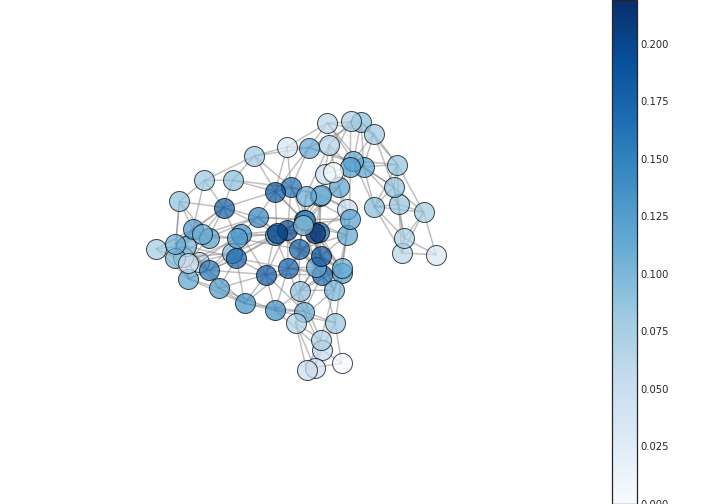

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [177]:
G_draw_node(Gw_l, twnode_vec_l['op_mean'].values.astype('float64'), xyz_l, 90, 90)
